## Import the necessary modules

In [1]:
%matplotlib inline
import pandas as pd
import numpy
import scipy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns

## Retrieve necessary data and load into Pandas DataFrame

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
names=['code', 'cl_thick', 'c_size', 'c_shape', 'marg_adh', 's_ep_c_size', 
       'b_nuclei', 'b_chromatin', 'n_nucleoli', 'mitoses', 'diag'] 
data = pd.read_csv(url, names=names)
array = data.values

Take an initial look at the data

In [3]:
data.head()

,code,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_nuclei,b_chromatin,n_nucleoli,mitoses,diag
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Since the "code" column is just an arbitrary identifier, let's remove it

In [4]:
data.drop('code', axis=1, inplace=True)
data.head()

,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_nuclei,b_chromatin,n_nucleoli,mitoses,diag
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


...and take a look at the shape of the data (699 rows, 10 columns)

In [5]:
data.shape

(699, 10)

Now, let's take a deeper look a the data

In [6]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
description = data.describe()
print(description)

       cl_thick   c_size  c_shape  marg_adh  s_ep_c_size  b_chromatin  n_nucleoli  mitoses  \
count   699.000  699.000  699.000   699.000      699.000      699.000     699.000  699.000   
mean      4.418    3.134    3.207     2.807        3.216        3.438       2.867    1.589   
std       2.816    3.051    2.972     2.855        2.214        2.438       3.054    1.715   
min       1.000    1.000    1.000     1.000        1.000        1.000       1.000    1.000   
25%       2.000    1.000    1.000     1.000        2.000        2.000       1.000    1.000   
50%       4.000    1.000    1.000     1.000        2.000        3.000       1.000    1.000   
75%       6.000    5.000    5.000     4.000        4.000        5.000       4.000    1.000   
max      10.000   10.000   10.000    10.000       10.000       10.000      10.000   10.000   

          diag  
count  699.000  
mean     2.690  
std      0.951  
min      2.000  
25%      2.000  
50%      2.000  
75%      4.000  
max      4.000  


Did you notice something? The b_nuclei column was excluded. Let's dig a bit to see why.

In [7]:
data.dtypes

cl_thick        int64
c_size          int64
c_shape         int64
marg_adh        int64
s_ep_c_size     int64
b_nuclei       object
b_chromatin     int64
n_nucleoli      int64
mitoses         int64
diag            int64
dtype: object

It looks like Pandas has identified the b_nuclei column as an 'object' instead of as a number - here's why:

In [8]:
pd.unique(data.b_nuclei.ravel())

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'], dtype=object)

The '?'s in that column made it treat the whole column as an object. In order to use this column we will have to convert the
non-numeric values to numeric values and convert this column type to a numeric one. 

In [9]:
#data.b_nuclei.replace(['?'],['-1'],inplace=True)

In [10]:
#Convert the '?' to some easily identified value that can be converted to an integer
data['b_nuclei'] = data['b_nuclei'].apply(lambda x: x if x != '?' else '-1')
#convert the column to an integer
data.b_nuclei = data.b_nuclei.astype('int')

In [11]:
#get the mean of all of the values, EXCEPT for the value that we used in place of the '?'
mean = int(round(data[data.b_nuclei != -1].b_nuclei.mean()))
print('The mean of the column is: ' + str(mean))
data['b_nuclei'] = data['b_nuclei'].apply(lambda x: x if x != -1 else mean)

The mean of the column is: 4


If we take another look at all of the unique values in the b_nuclei column, we can see that '?' is gone and the data type is an
int64.

In [12]:
pd.unique(data.b_nuclei.ravel())

array([ 1, 10,  2,  4,  3,  9,  7,  5,  8,  6], dtype=int64)

When we describe the data again, we will see that the b_nuclei is included in the results

In [15]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
description = data.describe()
print(description)

       cl_thick   c_size  c_shape  marg_adh  s_ep_c_size  b_nuclei  b_chromatin  n_nucleoli  \
count   699.000  699.000  699.000   699.000      699.000   699.000      699.000     699.000   
mean      4.418    3.134    3.207     2.807        3.216     3.555        3.438       2.867   
std       2.816    3.051    2.972     2.855        2.214     3.602        2.438       3.054   
min       1.000    1.000    1.000     1.000        1.000     1.000        1.000       1.000   
25%       2.000    1.000    1.000     1.000        2.000     1.000        2.000       1.000   
50%       4.000    1.000    1.000     1.000        2.000     1.000        3.000       1.000   
75%       6.000    5.000    5.000     4.000        4.000     5.000        5.000       4.000   
max      10.000   10.000   10.000    10.000       10.000    10.000       10.000      10.000   

       mitoses     diag  
count  699.000  699.000  
mean     1.589    2.690  
std      1.715    0.951  
min      1.000    2.000  
25%      1.000

The next step is to look a the corrleation beteen the columns and the dianosis to identify which ones should be used to train
our model

In [29]:
#correlations = 
data.corr(method='pearson')
#print(correlations)

,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_nuclei,b_chromatin,n_nucleoli,mitoses,diag
cl_thick,1.000,0.645,0.655,0.486,0.522,0.586,0.558,0.536,0.350,0.716
c_size,0.645,1.000,0.907,0.706,0.752,0.686,0.756,0.723,0.459,0.818
c_shape,0.655,0.907,1.000,0.683,0.720,0.709,0.736,0.719,0.439,0.819
marg_adh,0.486,0.706,0.683,1.000,0.600,0.664,0.667,0.603,0.418,0.697
s_ep_c_size,0.522,0.752,0.720,0.600,1.000,0.580,0.616,0.629,0.479,0.683
b_nuclei,0.586,0.686,0.709,0.664,0.580,1.000,0.675,0.577,0.338,0.815
b_chromatin,0.558,0.756,0.736,0.667,0.616,0.675,1.000,0.666,0.344,0.757
n_nucleoli,0.536,0.723,0.719,0.603,0.629,0.577,0.666,1.000,0.428,0.712
mitoses,0.350,0.459,0.439,0.418,0.479,0.338,0.344,0.428,1.000,0.423
diag,0.716,0.818,0.819,0.697,0.683,0.815,0.757,0.712,0.423,1.000


This is easier to understand using a graph - in this case a heatmap. Using the scale on the right, we can see that colors that are darker read are closer to 1.0 (meaning a perfect correlation between the the row and the column), colors that are yellower are closer to 0.0 (no correlation), and colors that are darker green are closer to -1.0 (meaning a negative correlation - as one goes up the other goes down).

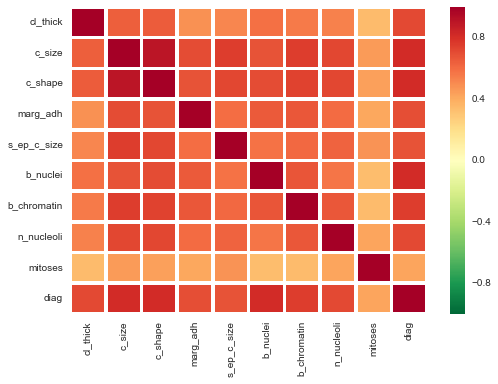

In [17]:
correlations = data.corr(method='pearson')
sns.heatmap(correlations, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, linewidths=2.5)

It looks like c_size (0.818), c_shape (0.819), and b_nuclei (0.815) have the strongest correlation with the diagnosis while marg_adh (0.697) and mitoes (0.423) have the least strong correlation (numbers taken from the printed correlation above). 

For now, since this is a small dataset and all of the correlations are "pretty good" we will keep all of them for now and look at the accuracy of our model. 

The next step is to look at the accuracy of our model.

In [18]:
[data[data.diag == 2].shape[0],data[data.diag != 2].shape[0]]

[458, 241]

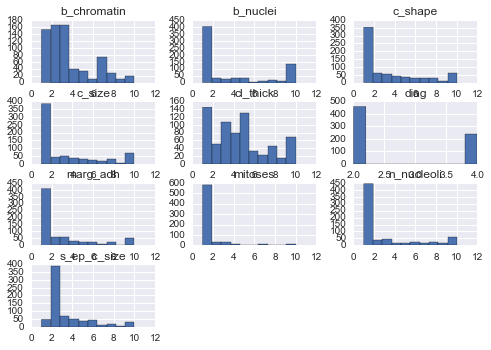

In [19]:
data.hist()
plt.show()

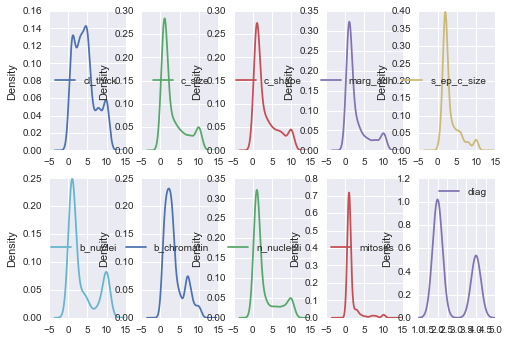

In [37]:
data.plot(kind= 'density' , subplots=True, layout=(2,5), sharex=False)
plt.show()

In [25]:
# calculate the correlations
coefficients = ['pearson'] #, 'kendall', 'spearman']

csv_corr = {}

for coefficient in coefficients:
    csv_corr[coefficient] = data \
        .corr(method=coefficient) \
        .transpose()
        
print(csv_corr)

{'pearson':              cl_thick  c_size  c_shape  marg_adh  s_ep_c_size  b_nuclei  b_chromatin  n_nucleoli  \
cl_thick        1.000   0.645    0.655     0.486        0.522     0.586        0.558       0.536   
c_size          0.645   1.000    0.907     0.706        0.752     0.686        0.756       0.723   
c_shape         0.655   0.907    1.000     0.683        0.720     0.709        0.736       0.719   
marg_adh        0.486   0.706    0.683     1.000        0.600     0.664        0.667       0.603   
s_ep_c_size     0.522   0.752    0.720     0.600        1.000     0.580        0.616       0.629   
b_nuclei        0.586   0.686    0.709     0.664        0.580     1.000        0.675       0.577   
b_chromatin     0.558   0.756    0.736     0.667        0.616     0.675        1.000       0.666   
n_nucleoli      0.536   0.723    0.719     0.603        0.629     0.577        0.666       1.000   
mitoses         0.350   0.459    0.439     0.418        0.479     0.338        0.344    

In [28]:
# calculate the correlations
coefficients = ['pearson'] #, 'kendall', 'spearman']

data.corr(method='pearson').transpose()

,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_nuclei,b_chromatin,n_nucleoli,mitoses,diag
cl_thick,1.000,0.645,0.655,0.486,0.522,0.586,0.558,0.536,0.350,0.716
c_size,0.645,1.000,0.907,0.706,0.752,0.686,0.756,0.723,0.459,0.818
c_shape,0.655,0.907,1.000,0.683,0.720,0.709,0.736,0.719,0.439,0.819
marg_adh,0.486,0.706,0.683,1.000,0.600,0.664,0.667,0.603,0.418,0.697
s_ep_c_size,0.522,0.752,0.720,0.600,1.000,0.580,0.616,0.629,0.479,0.683
b_nuclei,0.586,0.686,0.709,0.664,0.580,1.000,0.675,0.577,0.338,0.815
b_chromatin,0.558,0.756,0.736,0.667,0.616,0.675,1.000,0.666,0.344,0.757
n_nucleoli,0.536,0.723,0.719,0.603,0.629,0.577,0.666,1.000,0.428,0.712
mitoses,0.350,0.459,0.439,0.418,0.479,0.338,0.344,0.428,1.000,0.423
diag,0.716,0.818,0.819,0.697,0.683,0.815,0.757,0.712,0.423,1.000


In [24]:
array = data.values
X = array[:,0:8]
Y = array[:,8]
X[1]
# # feature extraction
# test = SelectKBest(score_func=chi2, k=4)
# fit = test.fit(X, Y)
# # summarize scores
# numpy.set_printoptions(precision=3)
# print(fit.scores_)
# features = fit.transform(X)
# # summarize selected features
# #print(features[0:5,:])

array([ 5,  4,  4,  5,  7, 10,  3,  2], dtype=int64)